In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import statsmodels.api as sm

plt.style.use('ggplot')

In [2]:
COUNTRY = 'Malawi'
START = 2000
YEAR = 2021
INTERVENTION = 2025
COUNTERFACTUAL = INTERVENTION + 8

DISCOUNT = 0.04
SOURCE = 0.25

STEP = 5
AGES = np.arange(0, 80 + STEP, STEP)
COLUMNS = [str(AGES[i]) + '-' + str(AGES[i + 1] - 1) for i in range(len(AGES) - 1)]

COLOR = [mpl.cm.cividis(x) for x in np.linspace(1, 0, len(COLUMNS))]
COLOR3 = [mpl.cm.cividis(x) for x in np.linspace(1, 0, 3)]
KARGS = {'color': COLOR, 'legend': False, 'linewidth': 3}
FIGSIZE = (14, 8)

# https://stackoverflow.com/a/30781039
cmap, norm = mpl.colors.from_levels_and_colors(AGES, COLOR)
SM = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
SM.set_array([])

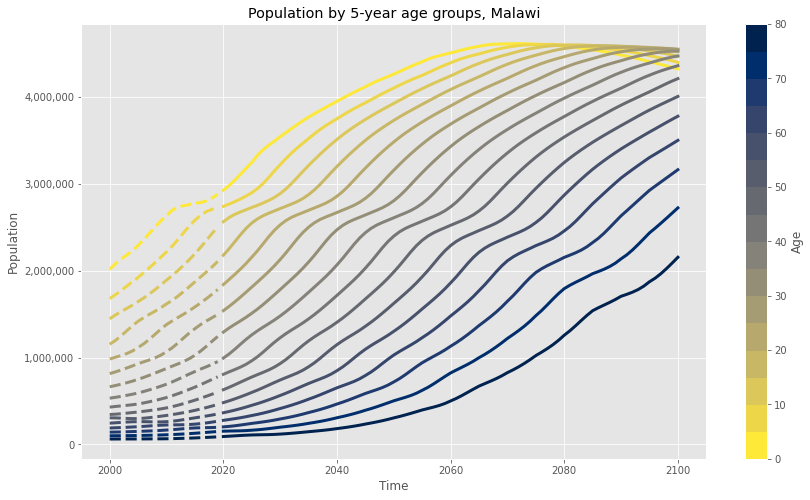

In [3]:
# https://population.un.org/wpp/Download/Standard/CSV/
df = pd.read_csv('WPP2019_PopulationByAgeSex_Medium.csv')
df = df[df['Location'] == COUNTRY].pivot_table('PopTotal', 'Time', 'AgeGrp')

pop = df[COLUMNS].loc[START:]*1e3

fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_title('Population by 5-year age groups, %s' % COUNTRY)
ax.set_ylabel('Population')
_ = pop.loc[:2019].plot(ax=ax, linestyle='--', **KARGS)
_ = pop.loc[2020:].plot(ax=ax, **KARGS)
_ = fig.colorbar(SM, label='Age')

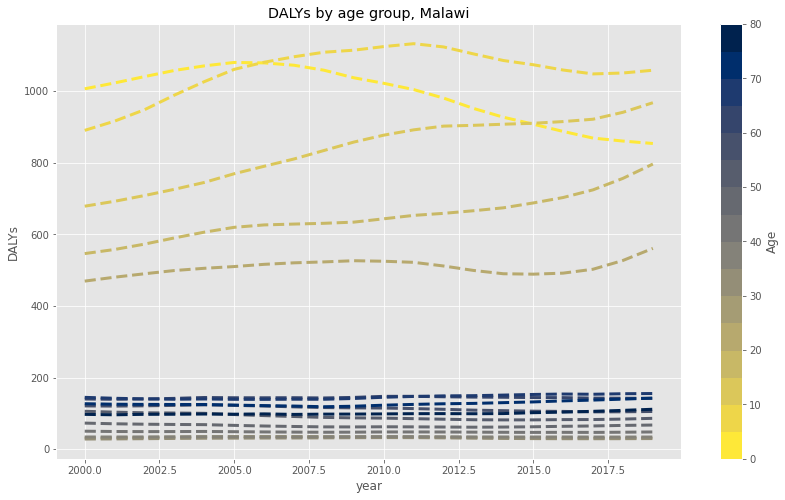

In [4]:
# http://ghdx.healthdata.org/gbd-results-tool?params=gbd-api-2019-permalink/31dd9609036871b0e51adfd08e154284
files = []
for file in os.listdir('.'):
    if re.match('IHME-GBD_2019_DATA-711e32d7-\d+.csv', file):
        files.append(file)
df = pd.concat(pd.read_csv(file) for file in files)
df = df[df['location'] == COUNTRY].pivot_table('val', 'year', 'age')
df.columns = [re.sub(' to ', '-', column) for column in df.columns]
df['0-4'] = df['Under 5']
df['95-99'] = df['95 plus']

dalys = df[COLUMNS].loc[START:]

fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
ax.set_title('DALYs by age group, %s' % COUNTRY)
ax.set_ylabel('DALYs')
_ = dalys.plot(ax=ax, linestyle='--', **KARGS)
_ = fig.colorbar(SM, label='Age')

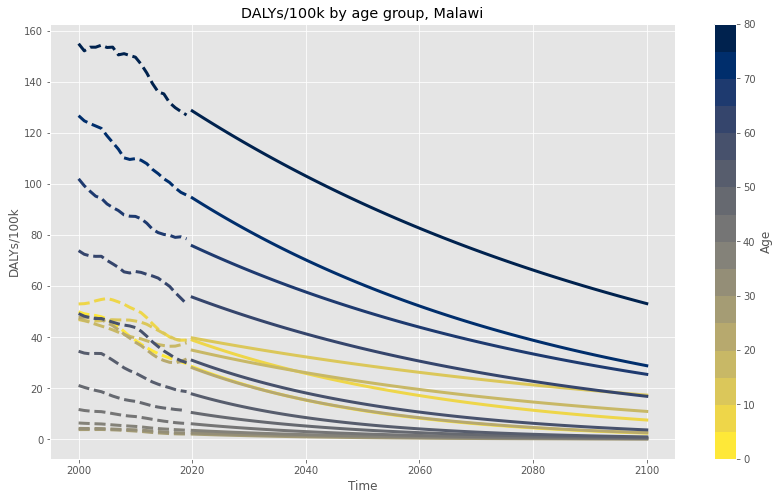

In [5]:
rate = (dalys/pop).dropna(how='all')*1e5

pred = pd.DataFrame(index=pop.index[pop.index > rate.index[-1]], columns=COLUMNS)
for column in COLUMNS:
    X = rate.index
    X = sm.add_constant(X)
    y = np.log(rate[column])
    model = sm.OLS(y, X).fit()
    
    X_pred = pred.index
    X_pred = sm.add_constant(X_pred)
    pred[column] = np.exp(model.predict(X_pred))

fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
ax.set_ylabel('DALYs/100k')
ax.set_title('DALYs/100k by age group, %s' % COUNTRY)
_ = rate.plot(ax=ax, linestyle='--', **KARGS)
_ = pred.plot(ax=ax, **KARGS)
_ = fig.colorbar(SM, label='Age')

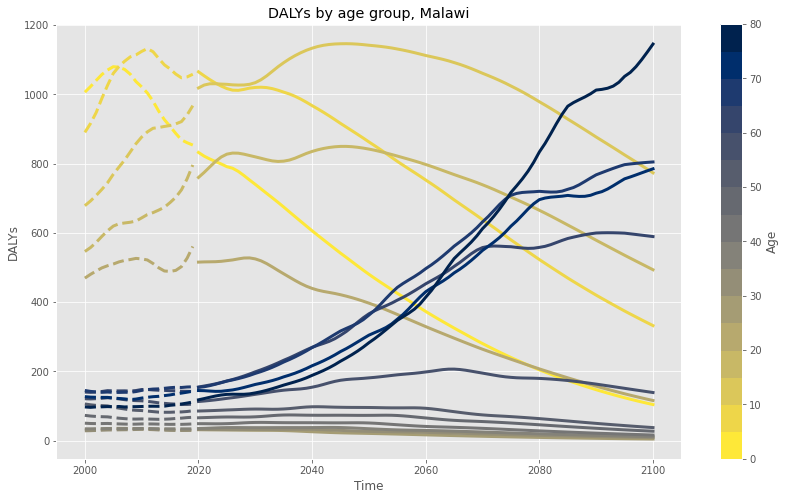

In [6]:
proj = pop.loc[pred.index[0]:]*pred/1e5

fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
ax.set_title('DALYs by age group, %s' % COUNTRY)
ax.set_ylabel('DALYs')
_ = dalys.plot(ax=ax, linestyle='--', **KARGS)
_ = proj.plot(ax=ax, **KARGS)
_ = fig.colorbar(SM, label='Age')

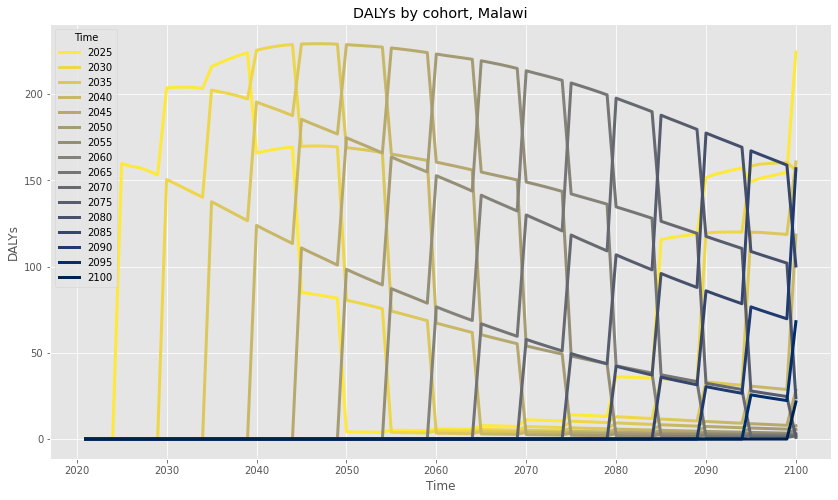

In [16]:
cohorts = pd.DataFrame(0.0, index=proj.index[proj.index >= YEAR], columns=proj.index[proj.index >= INTERVENTION])

for i in range(len(cohorts.columns)):
    birth = cohorts.columns[i]
    for j in range(len(cohorts.index)):
        year = cohorts.index[j]
        k = np.argwhere((year - birth) >= AGES)
        if k.size > 0:
            cohorts.iloc[j, i] = proj[COLUMNS[np.max(k)]].iloc[j]/STEP

fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
ax.set_title('DALYs by cohort, %s' % COUNTRY)
ax.set_ylabel('DALYs')
_ = cohorts[INTERVENTION + AGES[:-1]].plot(ax=ax, color=COLOR, linewidth=3)

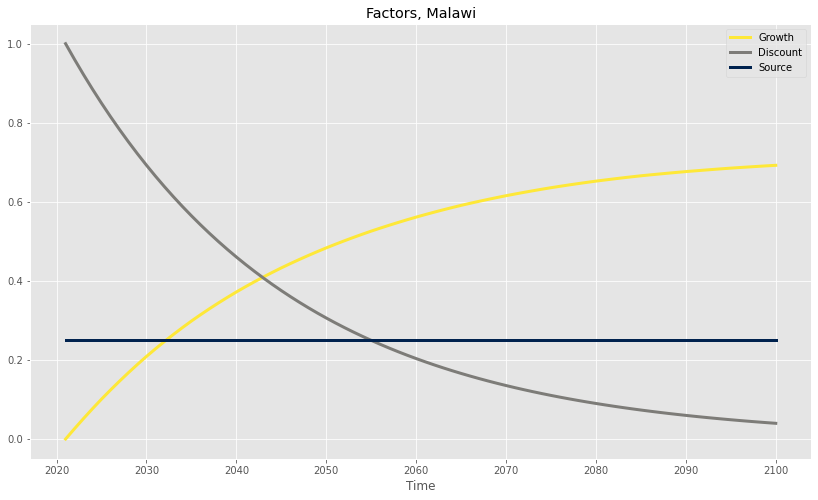

In [20]:
growth = (1 + pop.sum(axis=1).pct_change()).cumprod().fillna(1.0)

factor = pd.DataFrame(index=cohorts.index, columns=['Growth', 'Discount', 'Source'])
s = growth.copy()
s.loc[YEAR:] = growth.loc[YEAR]
factor['Growth'] = (1 - s.div(growth))
factor['Discount'] = pd.Series(np.power((1 - DISCOUNT), (cohorts.index - YEAR)), index=cohorts.index)
factor['Source'] = SOURCE

fig, ax = plt.subplots(1, 1, figsize=(FIGSIZE))
ax.set_title('Factors, %s' % COUNTRY)
ax.set_ylabel('')
_ = factor.plot(ax=ax, color=COLOR3, linewidth=3)

In [9]:
# Simulate an intervention. Only count projected DALYs of cohorts born after start (interpolating as necessary).
# Only count for fraction of cohort living in new construction (assumed from population growth) without leaded paint.
def sim(year, cohorts, growth):
    df = cohorts[cohorts.columns[cohorts.columns > year]]
    s = growth.copy()
    s.loc[year:] = growth.loc[year]
    return df.multiply(1.0 - s.div(growth), axis=1).dropna(axis=1)

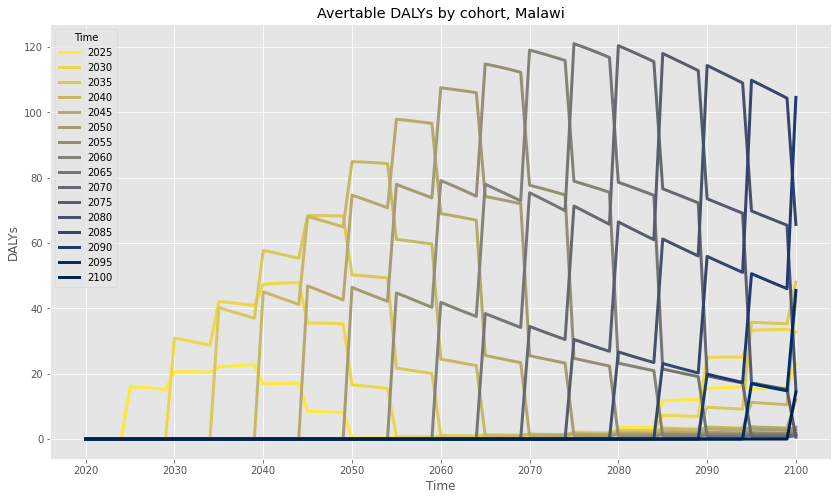

In [10]:
intervention = sim(YEAR, cohorts, growth)

fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
ax.set_title('Avertable DALYs by cohort, %s' % COUNTRY)
ax.set_ylabel('DALYs')
_ = intervention[INTERVENTION + AGES[:-1]].plot(ax=ax, color=COLOR, linewidth=3)

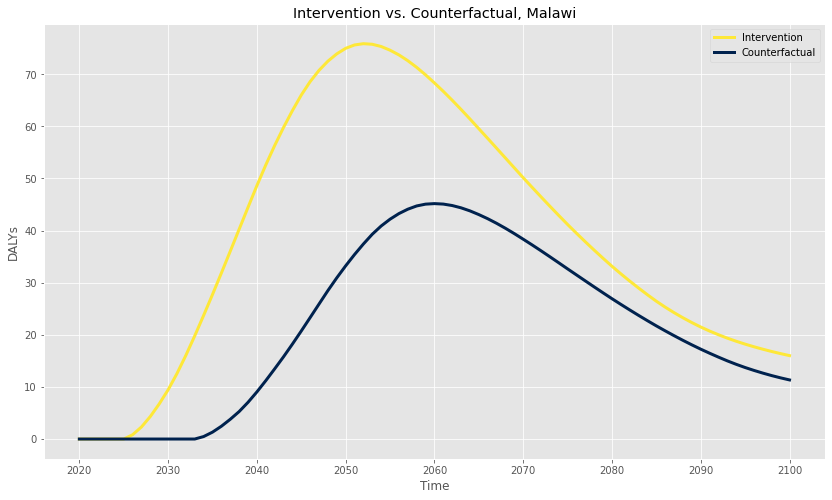

In [11]:
f = factor['Discount']*factor['Source']

results = pd.DataFrame(index=proj.index, columns=['Intervention', 'Counterfactual'])
results['Intervention'] = sim(INTERVENTION, cohorts, growth).sum(axis=1)*f
results['Counterfactual'] = sim(COUNTERFACTUAL, cohorts, growth).sum(axis=1)*f

fig, ax = plt.subplots(1, 1, figsize=(FIGSIZE))
ax.set_title('Intervention vs. Counterfactual, %s' % COUNTRY)
ax.set_ylabel('DALYs')
_ = results.plot(ax=ax, color=[COLOR3[0], COLOR3[-1]], linewidth=3)

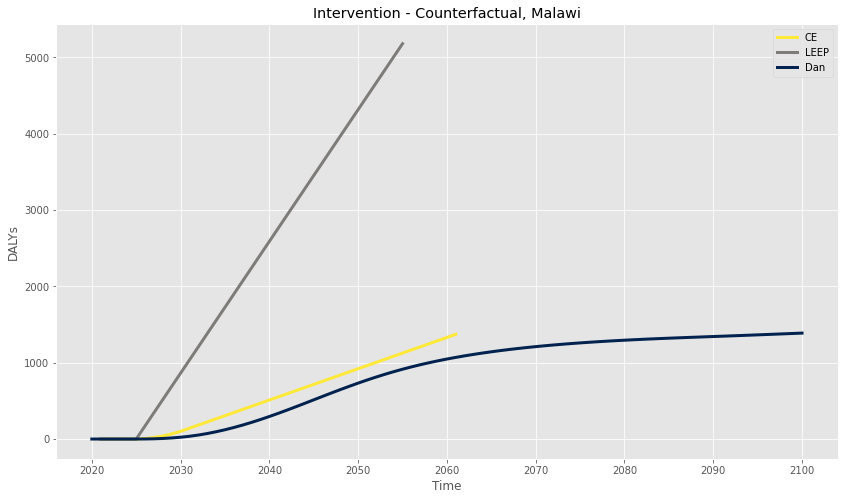

In [12]:
diff = pd.DataFrame(index=proj.index, columns=['CE', 'LEEP', 'Dan'])
diff['CE'] = pd.Series(np.array([0, 0, 0, 0, 0, 7, 13, 20, 27, 34, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41]), index=np.arange(YEAR, YEAR + 41))
diff['LEEP'] = pd.Series(np.hstack([np.zeros(5), np.ones(30)*24300*0.007105]), np.arange(YEAR, YEAR + 35))
diff['Dan'] = results['Intervention'] - results['Counterfactual']

fig, ax = plt.subplots(1, 1, figsize=(FIGSIZE))
ax.set_title('Intervention - Counterfactual, %s' % COUNTRY)
ax.set_ylabel('DALYs')
_ = diff.cumsum().plot(ax=ax, color=COLOR3, linewidth=3)